### import libaries

In [1]:
import urllib.request
import os 
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from shutil import copyfile

### getting the dataset

In [2]:
data_url='https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
data_file_name='catsdogs.zip'
download_dir='/tmp/'
urllib.request.urlretrieve(data_url,data_file_name)
zip_ref=zipfile.ZipFile(data_file_name,'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [3]:
print("Number of cat images : ",len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images :",len(os.listdir('/tmp/PetImages/Dog')))

Number of cat images :  12501
Number of dog images : 12501


In [4]:
try:
    os.makedirs('/tmp/cats-v-dogs')
    os.makedirs('/tmp/cats-v-dogs/training')
    os.makedirs('/tmp/cats-v-dogs/testing')
    os.makedirs('/tmp/cats-v-dogs/training/cats')
    os.makedirs('/tmp/cats-v-dogs/training/dogs')
    os.makedirs('/tmp/cats-v-dogs/testing/cats')
    os.makedirs('/tmp/cats-v-dogs/testing/dogs')
except:
    pass

### split the dataset

In [5]:
def split_data(SOURCE,TRAINING,TESTING,SPLIT_SIZE):
    files=[]
    for filename in os.listdir(SOURCE):
        file=SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename+ 'is Zero lenght, so ignore it')
    training_length =int(len(files) * SPLIT_SIZE)
    testing_length =int(len(files) - training_length)
    shuffled_set = random.sample(files,len(files))
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)

In [6]:
CAT_SOURCE_DIR='/tmp/PetImages/Cat/'
TRAINING_CATS_DIR='/tmp/cats-v-dogs/training/cats/'
TESTING_CATS_DIR='/tmp/cats-v-dogs/testing/cats/'
DOG_SOURCE_DIR='/tmp/PetImages/Dog/'
TRAINING_DOGS_DIR='/tmp/cats-v-dogs/training/dogs/'
TESTING_DOG_DIR='/tmp/cats-v-dogs/testing/dogs/'

split_size=0.9

split_data(CAT_SOURCE_DIR,TRAINING_CATS_DIR,TESTING_CATS_DIR,split_size)
split_data(DOG_SOURCE_DIR,TRAINING_DOGS_DIR,TESTING_DOG_DIR,split_size)

666.jpgis Zero lenght, so ignore it
11702.jpgis Zero lenght, so ignore it


### check the size of the data

In [7]:
print("Number of training cat images : ",len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of testing cat images : ",len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of training dog images : ",len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing dog images : ",len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images :  11250
Number of testing cat images :  1250
Number of training dog images :  11250
Number of testing dog images :  1250


### Data Augmentation 

In [8]:
TRAINING_DIR='/tmp/cats-v-dogs/training/'
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator=train_datagen.flow_from_directory(TRAINING_DIR,
                                                 batch_size=100,
                                                 class_mode='binary',
                                                 target_size=(150,150))
VALIDATION_DIR='/tmp/cats-v-dogs/testing/'
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_genrator=validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                          batch_size=100,
                                                          class_mode='binary',
                                                          target_size=(150,150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### Get the  Inception model

In [9]:
weights_url='https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_file='inception_v3.h5'
urllib.request.urlretrieve(weights_url,weight_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x2771a46ac50>)

In [10]:
pre_trained_model=InceptionV3(input_shape=(150,150,3),include_top=False,weights=None)

pre_trained_model.load_weights(weight_file)

### freeze the layers

In [11]:
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [12]:
last_layer=pre_trained_model.get_layer('mixed7')
print("Last layer output shape",last_layer.output_shape)

Last layer output shape (None, 7, 7, 768)


In [13]:
last_output=last_layer.output
print(last_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


### add my layers

In [14]:
x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dense(1,activation='sigmoid')(x)

### create the model 

In [15]:
model=Model(pre_trained_model.input,x)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

### compile the model 

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])

### train the model 

In [18]:
import warnings
warnings.filterwarnings('ignore')
history=model.fit(
    train_generator,validation_data=validation_genrator,epochs=20
)

Epoch 1/20
225/225 [==============================] - 270s 1s/step - loss: 0.1754 - acc: 0.9263 - val_loss: 0.0693 - val_acc: 0.9724
Epoch 2/20
225/225 [==============================] - 194s 864ms/step - loss: 0.1282 - acc: 0.9472 - val_loss: 0.0545 - val_acc: 0.9772
Epoch 3/20
225/225 [==============================] - 196s 871ms/step - loss: 0.1158 - acc: 0.9522 - val_loss: 0.0525 - val_acc: 0.9792
Epoch 4/20
225/225 [==============================] - 195s 866ms/step - loss: 0.1077 - acc: 0.9572 - val_loss: 0.0480 - val_acc: 0.9824
Epoch 5/20
225/225 [==============================] - 195s 865ms/step - loss: 0.1061 - acc: 0.9565 - val_loss: 0.0510 - val_acc: 0.9804
Epoch 6/20
225/225 [==============================] - 197s 876ms/step - loss: 0.0994 - acc: 0.9606 - val_loss: 0.0549 - val_acc: 0.9788
Epoch 7/20
225/225 [==============================] - 195s 868ms/step - loss: 0.0930 - acc: 0.9624 - val_loss: 0.0466 - val_acc: 0.9800
Epoch 8/20
225/225 [==============================]

### plot the training and validation accuracy

In [23]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

In [24]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

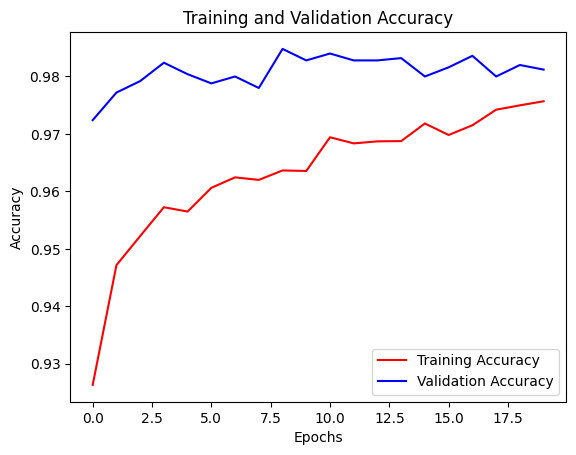

In [25]:
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')



# Display the legend
plt.legend()

# Show the plot
plt.show()


### predict the image

1/1 [==============================] - 1s 921ms/step
The image is a cat


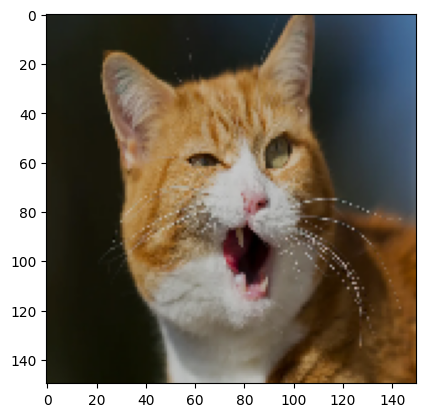

In [28]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

# Load image from a specific file path
image_path = "1.png"  # Replace with your image's file path    
img = load_img(image_path, target_size=(150, 150))  # Set target size if needed
x = img_to_array(img)
x /= 255  # Normalize to [0, 1]
x = np.expand_dims(x, axis=0)  # Add batch dimension

# Predict with the model
classes = model.predict(x)  # Predicting a single image
prediction = classes[0]  # Get the prediction result
plt.imshow(img)
# Classify based on threshold
if prediction > 0.5:
    print("The image is a dog")
else:
    print("The image is a cat")